# Predective Model for Recessions 

## Importing Modules

In [1]:
#Selenium Imports
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchWindowException
#Threading library
import threading
#Data Manipulation Modules
import pandas as pd
from openpyxl import load_workbook
import re
from langdetect import detect, LangDetectException
#NLP and Sentiment Anlaysis Modules
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#Visualization Modules
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#SkLearn modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#Other Modules
from datetime import datetime, timedelta
import time
import numpy as np
import os



## Checking for Pre-Existing Datasets (Prep)

In [2]:
directory = os.getcwd()
datasetName = 'twitter_scrapped_dataset'
extension = '.xlsx'

files = os.listdir(directory)

datasetFiles = [f for f in files if f.startswith(datasetName) and f.endswith(extension)]

if datasetFiles:
    datasetFiles.sort(key=lambda x: int(re.search(r'\(v(\d+)\)', x).group(1)) if re.search(r'\(v(\d+)\)', x) else 0, reverse=True)
    latestFile = datasetFiles[0]
    datasetPath = os.path.join(directory, latestFile)
else:
    datasetPath = None

if datasetPath and os.path.exists(datasetPath):
    df = pd.read_excel(datasetPath)
    
    df['date'] = pd.to_datetime(df['date'])
    
    lowestDate = df['date'].min()
    
    adjustedDate = lowestDate - timedelta(days=1)
else:
    adjustedDate = datetime(2009, 1, 1)

adjustedDateString = adjustedDate.strftime('%Y-%m-%d')

## Scrapping

### Twitter Scrapper Function

In [23]:
lock = threading.Lock()

def twitterScrapper(link, credentials, searchFilter, dataSet):    
    driverOpts = Options()

    driverOpts.headless = True
    
    driver = webdriver.Chrome(options=driverOpts)

    driver.get(link)
    try:
        # Login to twitter
        waitToLoad = WebDriverWait(driver, 20)
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[autocomplete="username"]'))).send_keys(credentials[0])
        driver.find_element(By.XPATH, ("//*[contains(text(), 'Next')]")).click();
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[autocomplete="current-password"]'))).send_keys(credentials[1])
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div[data-testid='LoginForm_Login_Button'][role='button']"))).click()
        
        #Add Search Filter
        searchBar = waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[data-testid='SearchBox_Search_Input'][role='combobox']")))
        searchBar.send_keys(searchFilter)
        searchBar.send_keys(Keys.ENTER)
        
        # Sort by Latest
        latestTab = waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div/div/div[2]/main/div/div/div/div/div/div[1]/div[1]/div[2]/nav/div/div[2]/div/div[2]//*[contains(text(), 'Latest')]")))
        latestTab.click()
        
        #Scrapping Tweets
        scrappedUserNames = []
        scrappedTweets = []
        scrappedTweetDate = []

        prevHeight = driver.execute_script('return document.body.scrollHeight')

        while True:
            time.sleep(10)

            users = driver.find_elements(By.XPATH, ("//div[@data-testid='User-Name']/div[1]/div[1]/a"))
            tweets = driver.find_elements(By.XPATH, ("//div[@data-testid='tweetText']"))
            tweetDates = driver.find_elements(By.XPATH, ("//div[@data-testid='User-Name']/div[2]/div[1]/div[3]/a/time"))
            
            for user in users:
                scrappedUserNames.append(user.text)
                
            for tweet in tweets:
                scrappedTweets.append(tweet.text)
                
            for date in tweetDates:
                scrappedTweetDate.append(date.text)

            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
            currentHeight = driver.execute_script('return document.body.scrollHeight')

            if (currentHeight == prevHeight):
                break
            
            prevHeight = currentHeight
            
    except NoSuchWindowException:
          print("Selenium window closed unexpectedly.")
        
    finally:
        driver.close()
        with lock:
            for username, tweet, date in zip(scrappedUserNames, scrappedTweets, scrappedTweetDate):
                dataSet[username] = [tweet, date]
        print("Scrapping is Completed")


### Threads Initalization and Scrapper Execution

In [24]:
scrapperInit = int(input("Scrap for training (0), Scrap for testing (1): "))

if scrapperInit == 0:
    twitterCredentials =[["ScrpperR16322", "Test8dcln"], ["TrentWaree30151", "Yam8dcln"]]
    searchFilter = [
        f'("business confidence" OR "economic growth" OR "fiscal policy" OR "monetary policy" OR "interest rates" OR "income inequality" OR "financial stability" OR "labor market" OR "economic indicators" OR "economic recovery" OR "cost of living") until:{adjustedDateString} since:2007-01-01 -filter:links -filter:replies',
        f'("economy" OR "economic" OR "job market" OR "unemployment" OR "inflation" OR "recession" OR "stock market" OR "GDP" OR "consumer spending") until:{adjustedDateString} since:2007-01-01 -filter:links -filter:replies'
    ]
    
    print("Search Start Date: ", adjustedDateString)
    
elif scrapperInit == 1:
    twitterCredentials =[["salem_mahm96058", "Test8dcln"], ["salem_mahm96058", "Test8dcln"]]
    searchFilter = [
        f'("business confidence" OR "economic growth" OR "fiscal policy" OR "monetary policy" OR "interest rates" OR "income inequality" OR "financial stability" OR "labor market" OR "economic indicators" OR "economic recovery" OR "cost of living") -filter:links -filter:replies',
        f'("economy" OR "economic" OR "job market" OR "unemployment" OR "inflation" OR "recession" OR "stock market" OR "GDP" OR "consumer spending") -filter:links -filter:replies'
    ]
    
else:
    print("Invalid Input!")
    exit()
    
linkTwitter = "https://twitter.com/i/flow/login"
scrappedTwitterData = {}

threads=[]
for i in range(len(searchFilter)):
        th = threading.Thread(target=twitterScrapper, args=(linkTwitter, twitterCredentials[i], searchFilter[i], scrappedTwitterData))
        threads.append(th)
        th.start()

for thread in threads:
    thread.join()

Exception in thread Thread-16 (twitterScrapper):
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_22896\3656554063.py", line 20, in twitterScrapper
  File "c:\Python312\Lib\site-packages\selenium\webdriver\support\wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF68BBA70C2+63090]
	(No symbol) [0x00007FF68BB12D12]
	(No symbol) [0x00007FF68B9AEC65]
	(No symbol) [0x00007FF68B9F499D]
	(No symbol) [0x00007FF68B9F4ADC]
	(No symbol) [0x00007FF68BA35B37]
	(No symbol) [0x00007FF68BA1701F]
	(No symbol) [0x00007FF68BA33412]
	(No symbol) [0x00007FF68BA16D83]
	(No symbol) [0x00007FF68B9E83A8]
	(No symbol) [0x00007FF68B9E9441]
	GetHandleVerifier [0x00007FF68BFA262D+4238301]
	GetHandleVerifier [0x00007FF68BFDF78D+4488509]
	GetHandleVerifier [0x00007FF68BFD7A6F+4456479]
	GetHandleVerifier [0x00007FF68BC80606+953270]
	(No symbol

KeyboardInterrupt: 

### Facebook Scrapper

In [ ]:
def isValidDate(text):
    try:
        datetime.strptime(text, '%d %B %Y')
        return True
    except ValueError:
        return False
   
def isNotUrl(url):
    return not validators.url(url)

def facebookScrapper(link, searchKeywords, credentials, dataSet, searchDates):
     driverOpts = Options()

     driverOpts.headless = False

     driver = webdriver.Chrome(options=driverOpts)

     driver.get(link)
     try:
          # Login to facebook
          waitToLoad = WebDriverWait(driver, 20)
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//input[@data-testid='royal_email']"))).send_keys(credentials[0])
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//input[@data-testid='royal_pass']"))).send_keys(credentials[1])
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//button[@data-testid='royal_login_button']"))).click()
          
          scrappedFacebookUserNames = []
          scrappedFacebookPosts = []
          scrappedFacebookDate = []
          
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "/html"))).click()
          
          # Scrapping
          for i in range(len(searchKeywords)):
               time.sleep(5)                    
               #Searching
               searchFacebook = waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[placeholder="Search Facebook"]')))                  
               searchFacebook.send_keys(Keys.CONTROL + "a")
               searchFacebook.send_keys(Keys.BACKSPACE)
               searchFacebook.send_keys(searchKeywords[i])
               searchFacebook.send_keys(Keys.ENTER)
               
               for date in searchDates:
                    time.sleep(2)                    
                    #Selecting Search Criteria
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Posts')]"))).click()
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Date posted')]"))).click()
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, f"//span[contains(text(),'{date}')]"))).click()
                    
                    #Selecting and Storing information
                    prevHeight = driver.execute_script('return document.body.scrollHeight')
                    while True:
                         duplicateDetected = False
                         time.sleep(5)

                         fbUsers = driver.find_elements(By.XPATH, "//a[contains(@class, 'x1i10hfl') and contains(@class, 'xjbqb8w') and contains(@class, 'x1ejq31n') and contains(@class, 'xd10rxx') and contains(@class, 'x1sy0etr') and contains(@class, 'x17r0tee') and contains(@class, 'x972fbf') and contains(@class, 'xcfux6l') and contains(@class, 'x1qhh985') and contains(@class, 'xm0m39n') and contains(@class, 'x9f619') and contains(@class, 'x1ypdohk') and contains(@class, 'xt0psk2') and contains(@class, 'xe8uvvx') and contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'xexx8yu') and contains(@class, 'x4uap5') and contains(@class, 'x18d9i69') and contains(@class, 'xkhd6sd') and contains(@class, 'x16tdsg8') and contains(@class, 'x1hl2dhg') and contains(@class, 'xggy1nq') and contains(@class, 'x1a2a7pz') and contains(@class, 'xt0b8zv') and contains(@class, 'xzsf02u') and contains(@class, 'x1s688f')]")
                         fbDates = driver.find_elements(By.XPATH, "//a[contains(@class, 'x1i10hfl') and contains(@class, 'xjbqb8w') and contains(@class, 'x1ejq31n') and contains(@class, 'xd10rxx') and contains(@class, 'x1sy0etr') and contains(@class, 'x17r0tee') and contains(@class, 'x972fbf') and contains(@class, 'xcfux6l') and contains(@class, 'x1qhh985') and contains(@class, 'xm0m39n') and contains(@class, 'x9f619') and contains(@class, 'x1ypdohk') and contains(@class, 'xt0psk2') and contains(@class, 'xe8uvvx') and contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'xexx8yu') and contains(@class, 'x4uap5') and contains(@class, 'x18d9i69') and contains(@class, 'xkhd6sd') and contains(@class, 'x16tdsg8') and contains(@class, 'x1hl2dhg') and contains(@class, 'xggy1nq') and contains(@class, 'x1a2a7pz') and contains(@class, 'x1heor9g') and contains(@class, 'xt0b8zv') and contains(@class, 'xo1l8bm')]")
                         fbPosts = fbPosts = driver.find_elements(By.XPATH, "//div[contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'x1vvkbs')]")

                         for post in fbPosts:
                              if post in scrappedFacebookPosts:
                                   duplicateDetected = True
                                   break
                              else:
                                   scrappedFacebookPosts.append(post.text) 
                         
                         if duplicateDetected:
                              break
                         
                         for date in fbDates:
                              if isValidDate(date.text):
                                  scrappedFacebookDate.append(date.text) 

                         for user in fbUsers:
                              if user.text != "See more" and isNotUrl(user.text):
                                  scrappedFacebookUserNames.append(user.text) 

                         driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                         currentHeight = driver.execute_script('return document.body.scrollHeight')

                         if (currentHeight == prevHeight) or (len(scrappedFacebookPosts) > 200):
                              break
                         
                         prevHeight = currentHeight
                         
                         print(scrappedFacebookUserNames)
                         print(scrappedFacebookPosts)
                         print(scrappedFacebookDate)
               
     except NoSuchWindowException:
          print("Selenium window closed unexpectedly.")
          
     print(len(scrappedFacebookPosts))
     print(len(scrappedFacebookUserNames))

In [ ]:
linkFacebook = "https://www.facebook.com/"
searchKeywords = ['economy', 'economic', 'job market', 'unemployment', 'inflation', 'recession', 'stock market', 'GDP', 'consumer spending', 'business confidence', 'economic growth', 'fiscal policy', 'monetary policy', 'interest rates', 'income inequality', 'financial stability', 'labor market', 'economic indicators', 'economic recovery', 'cost of living', "job loss", "homeless"]
facebookCredentials = ["fawdaclo@gmail.com", "Test8dcln"]
searchDates = [2007,2008]
scrappedFacebookData = {}


facebookScrapper(linkFacebook, searchKeywords, facebookCredentials, scrappedFacebookData, searchDates)


## Data Manipulation

### Creating CSV File From Data

In [6]:
currentDirectory = os.getcwd()
datasetPath = os.path.join(currentDirectory, datasetName)

def generateNewVersionPath(base_path, extension):
    version = 2
    base_path_without_extension = base_path
    if base_path.endswith(extension):
        base_path_without_extension = base_path[:-len(extension)]
    
    new_path = f"{base_path_without_extension} (v{version}){extension}"
    while os.path.exists(new_path):
        version += 1
        new_path = f"{base_path_without_extension} (v{version}){extension}"
    return new_path

newDf = pd.DataFrame({
    'username': scrappedTwitterData.keys(),
    'post': [v[0] for v in scrappedTwitterData.values()],
    'date': [v[1] for v in scrappedTwitterData.values()],
    'platform': ['Twitter'] * len(scrappedTwitterData)
})

if os.path.exists(datasetPath + extension):

    existingDf = pd.read_excel(datasetPath + extension)

    concatenatedDf = pd.concat([existingDf, newDf], ignore_index=True)

    datasetPath = generateNewVersionPath(datasetPath, extension)
    concatenatedDf.to_excel(datasetPath, index=False)
    print(f"Data saved in a new versioned file at {datasetPath}")
else:
    newDf.to_excel(datasetPath + extension, index=False)
    print(f"Data saved at {datasetPath + extension}")


Data saved in a new versioned file at s:\CS Projects\Recession-Predictive-Model\twitter_scrapped_dataset (v2).xlsx


### Data Cleaning

In [7]:
currentDirectory = os.getcwd()
cleanedDatasetPath = os.path.join(currentDirectory, 'recession_dataset_cleaned.xlsx')

#Language Detection Fucntion
def languageDetection(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

#Normalizing and Cleaning Text Data
def normalizeText(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove user mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters 
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data = pd.read_excel(datasetPath)

#Correcting Date Formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data.sort_values('date', inplace=True)

#Normalizing Text
data['post'] = data['post'].apply(normalizeText)

#Replacing all empty strings with NaN
data.replace('', np.nan, inplace=True)

#Removing all rows with empty or "NaN" posts Columns
data.dropna(subset=['post'], inplace=True)

#Detecting languages and keeping posts only written in english
data['language'] = data['post'].apply(lambda x: languageDetection(x))

data = data[data['language'] == 'en']

#Removing Duplicate Rows & Columns
data = data.drop_duplicates()

data.to_excel(cleanedDatasetPath, index=False)


## Analyzing Sentiment

### Creating Model for Sentiment Analysis

#### Implementing Regression & SkLearn

In [30]:
# Assuming the first column is named 'sentiment' and the second is named 'text'
# If your CSV doesn't have a header, you can assign column names manually
currentDirectory = os.getcwd()
sentimentTrainingDatasetPath = os.path.join(currentDirectory, "sentimentTrainerDataset.csv")

# Read the CSV and specify column names if the CSV doesn't have a header row
sentimentTrainingDataset = pd.read_csv(sentimentTrainingDatasetPath, encoding='ISO-8859-1', header=None, names=['sentiment', 'text'])

# Map sentiment labels to numerical scores
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
sentimentTrainingDataset['sentiment_score'] = sentimentTrainingDataset['sentiment'].map(sentiment_mapping)

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(sentimentTrainingDataset['text'], sentimentTrainingDataset['sentiment_score'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=60000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X_train_vectors, y_train)

RandomForestRegressor()

In [31]:
def sentimentAnalyzeReg(text):
    preprocessed_text = vectorizer.transform([text])
    sentiment_score = model.predict(preprocessed_text)
    return sentiment_score[0]

#### Implementing Vader Sentiment Analayzer

In [9]:
def sentimentAnalyzeVader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

#### Implementing TextBlob Sentiment Analyzer

In [33]:
negativeKeywords = ['unemployment', 'inflation', 'recession', 'interest rates', 'income inequality', "market crash", "poor", "unemployed", "homeless", "struggling", "high prices", "high mortgage", "lost house", "lost home", "move", "lost", "bankrupt"]

def sentimentAnalyzeTextBlob(text):
    blob = TextBlob(text)
    sentences = blob.sentences
    adjusted_sentiments = []
    
    for sentence in sentences:
        sentiment_score = sentence.sentiment.polarity
        if any(negKeyword.lower() in sentence.lower() for negKeyword in negativeKeywords):
            sentiment_score = min(sentiment_score, -0.2)
        elif -0.05 < sentiment_score < 0.05:
            sentiment_score = 0 
        adjusted_sentiments.append(sentiment_score)
    
    if not adjusted_sentiments:
        return 0
    
    return sum(adjusted_sentiments) / len(adjusted_sentiments)

#### Models Testing

In [16]:
testText = "I lost my job"

print(sentimentAnalyzeReg(testText))
print(sentimentAnalyzeVader(testText))
print(sentimentAnalyzeTextBlob(testText))


-0.39
-0.3182
-0.2


### Adding Sentiment Scores

In [10]:
currentDirectory = os.getcwd()
analyzedDatasetPath = os.path.join(currentDirectory, 'recession_sentiment_analysis.xlsx')

data = pd.read_excel(cleanedDatasetPath)

data['sentiment_score'] = data['post'].apply(sentimentAnalyzeVader) # Choose Model for Sentiment Anlayisis and add it here

data.to_excel(analyzedDatasetPath, index=False)

### Visualizing Snetiment

#### Sentiment Distribution

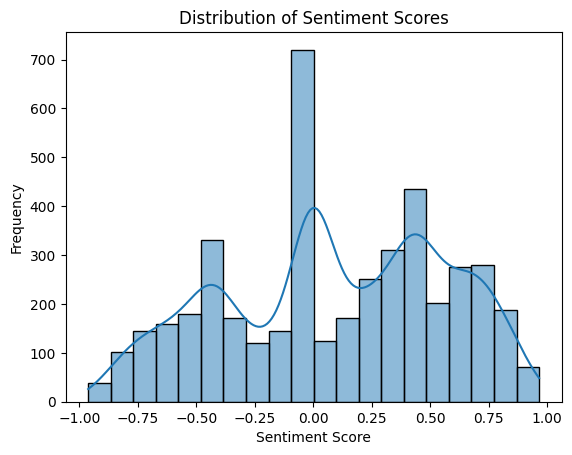

In [11]:
data = pd.read_excel(analyzedDatasetPath)

sns.histplot(data['sentiment_score'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

#### Sentiment Over Time

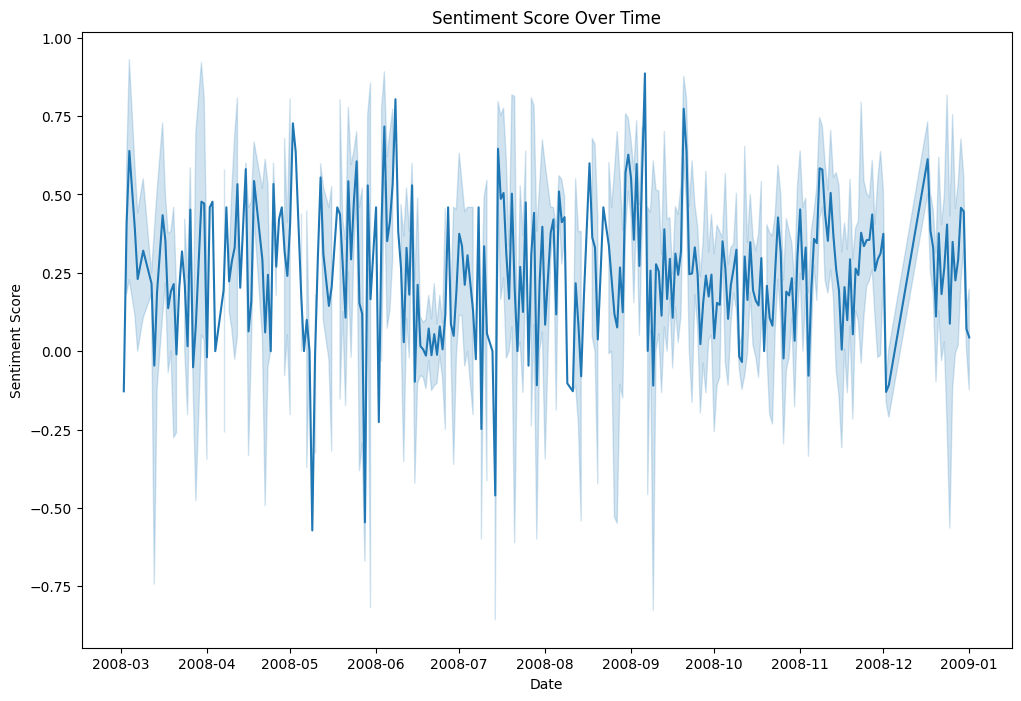

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='sentiment_score', data=data)
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

#### Word Clouds

Positive Word Cloud


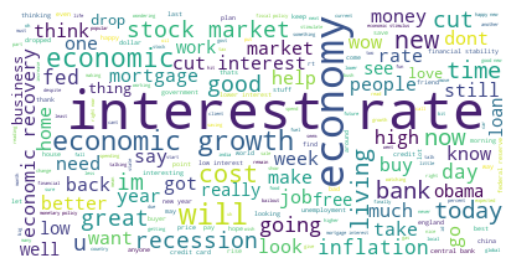

Negative Word Cloud


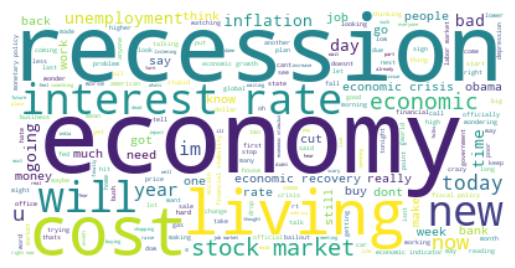

In [22]:
positiveTexts = data[data['sentiment_score'] > 0.1]
positiveString = ' '.join(positiveTexts['post'].tolist())
negativeTexts = data[data['sentiment_score'] < 0.1]
negativeString = ' '.join(negativeTexts['post'].tolist())

positiveWordCloud = WordCloud(background_color='white', max_words=200).generate(positiveString)
negativeWordCloud = WordCloud(background_color='white', max_words=200).generate(negativeString)

print("Positive Word Cloud")
plt.imshow(positiveWordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Negative Word Cloud")
plt.imshow(negativeWordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Predictive Model

### Adjusting Dataset
This will add a "recession" column to the dataset with boolean valuse which will be true if the tweet was published during a period of recession, and false if it wasn't

In [ ]:
currentDirectory = os.getcwd()
analyzedDatasetPath = os.path.join(currentDirectory, 'recession_sentiment_analysis.xlsx')

data = pd.read_excel(analyzedDatasetPath)

df['date'] = pd.to_datetime(df['date'])

startDate = pd.to_datetime('2007-12-01')
endDate = pd.to_datetime('2009-01-01')

df['recession'] = df['date'].apply(lambda x: startDate <= x <= endDate)

### Training model for Predicting Recession

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data[['sentiment']] 
y = data['recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predictRecessionModel = RandomForestClassifier()
predictRecessionModel.fit(X_train, y_train)

predictRecessionTest = np.mean(predictRecessionModel.predict_proba(X_test)[:, 1])

### Function for Applying the Model

In [ ]:
def calculateRecessionProbability(df, predictRecessionModel):
    X_new = df[['sentiment']]

    predictedRecession = predictRecessionModel.predict_proba(X_new)[:, 1]

    recessionProbability = np.mean(predictedRecession)
    
    return recessionProbability

new_data = ... 

recessionProbability = calculateRecessionProbability(new_data, predictRecessionModel)

print("Overall probability of recession:", recessionProbability)
